# ANFIS - Penguins dataset

BATCHESSSSS

In [1]:
import timeit 
import random as rd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from sklearn.dummy import DummyRegressor

from ANFIS import ANFIS

Here, we show an example of the ANFIS model implemented using the `penguins` dataset from `seaborn` module.

In [2]:
RANDOM_STATE = 12

## Example 1

Loading the dataset:

In [3]:
DATASET_NAME = "penguins"
FEATURES = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
TARGET = ["body_mass_g"]

df = sns.load_dataset(DATASET_NAME)

df = df.reindex(FEATURES + TARGET, axis=1)
df = df.dropna()  

X = df.reindex(FEATURES, axis=1)
y = df.reindex(TARGET, axis=1)

X = X.values
y = y.values.ravel() 

_x, x_test, _y, y_test = train_test_split(
                    X, y, test_size=0.1, random_state=RANDOM_STATE)

x_train, x_val, y_train, y_val = train_test_split(
                    _x, _y, test_size=0.1, random_state=RANDOM_STATE)

x_train = x_train / np.max(np.abs(x_train))
y_train = y_train / np.max(np.abs(y_train))

x_val = x_val / np.max(np.abs(x_val))
y_val = y_val / np.max(np.abs(y_val))

x_test = x_test / np.max(np.abs(x_test))
y_test = y_test / np.max(np.abs(y_test))

Defining the input variables information:

In [4]:
VARIABLES = {
    'inputs': {
        'bill_length': {'n_sets': 3, 'terms': ['short', 'medium', 'big'], 'universe_of_discourse': [0, 1]},
        'bill_depth': {'n_sets': 3, 'terms': ['short', 'medium', 'big'], 'universe_of_discourse': [0, 1]},
        'flipper_length': {'n_sets': 2, 'terms': ['short', 'big'], 'universe_of_discourse': [0, 1]},
    },
    'outputs': {
        'body_mass': {'n_sets': 2, 'terms': ['light', 'heavy'], 'universe_of_discourse': [0, 1]},
    }
}

Instantiating the model:

In [5]:
anfis = ANFIS(VARIABLES, 
              num_epochs=20,
              learning_algorithm='BatchLearning',
              learning_rate=0.01, 
              beta=0., 
              random_state=RANDOM_STATE,
             )

Fitting the data:

In [6]:
a = timeit.default_timer()

anfis.fit(x_train, x_val, y_train, y_val)

b = timeit.default_timer()

print(b-a)

 * Detected Sugeno model type
281.60395070002414


Plotting the learning curve:

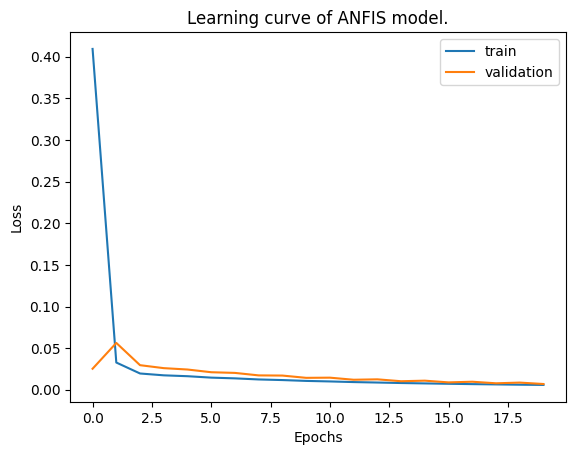

In [7]:
train = anfis.train_loss
validation = anfis.validation_loss
epochs = [i for i in range(len(train))]

plt.plot(epochs, train, label='train')
plt.plot(epochs, validation, label='validation')
plt.title('Learning curve of ANFIS model.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Showing the learned rules:

In [8]:
anfis.rules

['IF (bill_length IS short) AND (bill_depth IS short) AND (flipper_length IS short) THEN (body_mass IS y0)',
 'IF (bill_length IS short) AND (bill_depth IS short) AND (flipper_length IS big) THEN (body_mass IS y1)',
 'IF (bill_length IS short) AND (bill_depth IS medium) AND (flipper_length IS short) THEN (body_mass IS y2)',
 'IF (bill_length IS short) AND (bill_depth IS medium) AND (flipper_length IS big) THEN (body_mass IS y3)',
 'IF (bill_length IS medium) AND (bill_depth IS short) AND (flipper_length IS short) THEN (body_mass IS y6)',
 'IF (bill_length IS medium) AND (bill_depth IS short) AND (flipper_length IS big) THEN (body_mass IS y7)',
 'IF (bill_length IS medium) AND (bill_depth IS medium) AND (flipper_length IS short) THEN (body_mass IS y8)',
 'IF (bill_length IS medium) AND (bill_depth IS medium) AND (flipper_length IS big) THEN (body_mass IS y9)']

Plotting the variable universe of discourse and its fuzzy sets:

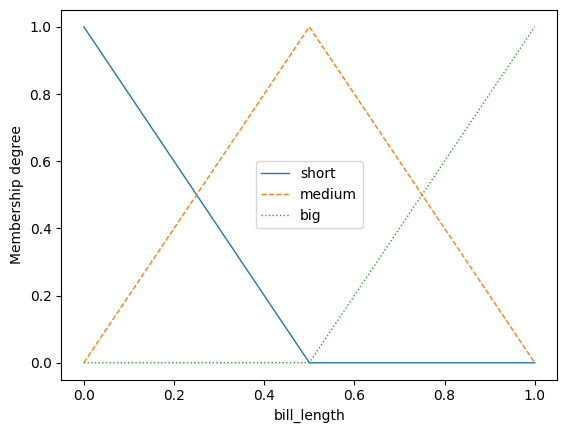

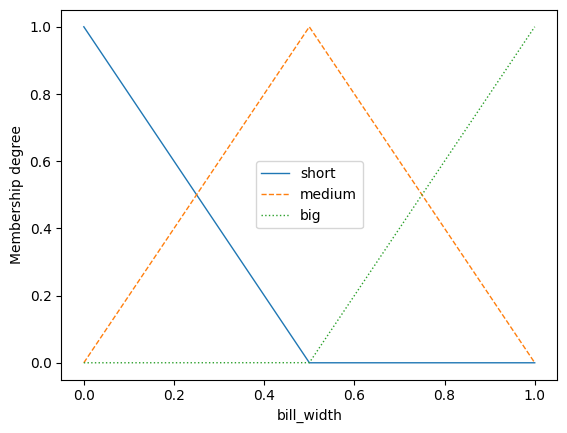

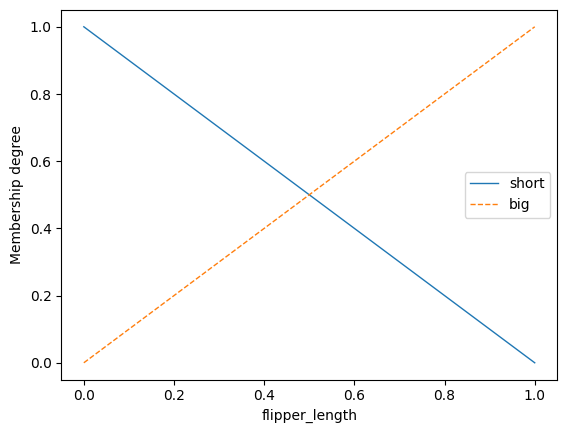

In [9]:
bill_len, bill_wid, flipper_len = anfis.input_variables[0], anfis.input_variables[1], anfis.input_variables[2]
bill_len._concept, bill_wid._concept, flipper_len._concept  = 'bill_length', 'bill_width', 'flipper_length'

bill_len.plot()
bill_wid.plot()
flipper_len.plot()

Calculating the RMSE of the model and the baseline value: 

In [10]:
y_pred_anfis = anfis.predict(x_test)
anfis_rmse = root_mean_squared_error(y_pred_anfis, y_test)

dummy = DummyRegressor(strategy='mean')
dummy.fit(x_train, y_train)
y_pred_dummy = dummy.predict(x_test)
dummy_rmse = root_mean_squared_error(y_pred_dummy, y_test)

print(f'dummy RMSE: {dummy_rmse}')
print()
print(f'anfis RMSE: {anfis_rmse}')

dummy RMSE: 0.1342934239523782

anfis RMSE: 0.09176374454569276


## Rule selection by limiar $\beta$

Here, we change the variable $\beta$ to select the most important rules.

In [11]:
anfis = ANFIS(VARIABLES, 
              num_epochs=20, 
              learning_algorithm='BatchLearning',
              learning_rate=0.05, 
              beta=0.05, 
              random_state=RANDOM_STATE)

In [12]:
a = timeit.default_timer()

anfis.fit(x_train, x_val, y_train, y_val)

b = timeit.default_timer()

print(b-a)

 * Detected Sugeno model type
117.44334440003149


Printing the rules:

In [13]:
anfis.rules

['IF (bill_length IS short) AND (bill_depth IS short) AND (flipper_length IS short) THEN (body_mass IS y0)',
 'IF (bill_length IS short) AND (bill_depth IS short) AND (flipper_length IS big) THEN (body_mass IS y1)',
 'IF (bill_length IS short) AND (bill_depth IS medium) AND (flipper_length IS big) THEN (body_mass IS y3)',
 'IF (bill_length IS medium) AND (bill_depth IS short) AND (flipper_length IS big) THEN (body_mass IS y7)']

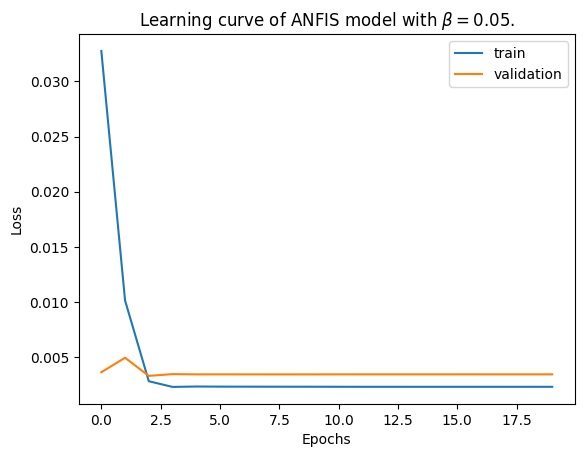

In [14]:
train = anfis.train_loss
validation = anfis.validation_loss
epochs = [i for i in range(len(train))]

plt.plot(epochs, train, label='train')
plt.plot(epochs, validation, label='validation')
plt.title(r'Learning curve of ANFIS model with $\beta=0.05$.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Calculating the RMSE of the model and the baseline value: 

In [15]:
y_pred_anfis = anfis.predict(x_test)
anfis_rmse = root_mean_squared_error(y_pred_anfis, y_test)

dummy = DummyRegressor(strategy='mean')
dummy.fit(x_train, y_train)
y_pred_dummy = dummy.predict(x_test)
dummy_rmse = root_mean_squared_error(y_pred_dummy, y_test)

print(f'dummy RMSE: {dummy_rmse}')
print()
print(f'anfis RMSE: {anfis_rmse}')

dummy RMSE: 0.1342934239523782

anfis RMSE: 0.07354333046718568
